<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/Chicago_Clear_LST_vs_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0
!pip install rasterio
!pip install rasterstats
!pip install earthpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [26]:
# Import necessary packages
import os, os.path
from glob import glob
from shutil import copyfile
import pickle
import requests

import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterstats import zonal_stats
from fiona.crs import from_epsg

import numpy as np
import pandas as pd
import geopandas as gpd

import earthpy.plot as ep
import earthpy.spatial as es

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from matplotlib import colors as colors
from pandas.plotting import scatter_matrix
import seaborn as sns

# Retrieve and process Chicago census tract information 

## From the Chicago data portal

* Boundaries - Census Tracts - 2010: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik

## From the Census API

General description of the Census Planning Database: https://www.census.gov/topics/research/guidance/planning-databases.2019.html
* Total population: https://api.census.gov/data/2019/pdb/tract/variables/Tot_Population_ACS_13_17.json
* Median household income variable: https://api.census.gov/data/2019/pdb/tract/variables/Med_HHD_Inc_ACS_13_17.json
* The percentage of people classified as below the poverty level in the ACS: https://api.census.gov/data/2019/pdb/tract/variables/pct_Prs_Blw_Pov_Lev_ACS_13_17.json
* Other available variables: https://api.census.gov/data/2019/pdb/tract/variables.html

In [27]:
# From the Chicago data portal
chi_tract = gpd.read_file('https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=GeoJSON', 
                   crs = from_epsg(2163)).to_crs(epsg = 4326)
chi_tract.info()                   
#chi_tract.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   statefp10   801 non-null    object  
 1   name10      801 non-null    object  
 2   commarea_n  801 non-null    object  
 3   namelsad10  801 non-null    object  
 4   commarea    801 non-null    object  
 5   geoid10     801 non-null    object  
 6   notes       801 non-null    object  
 7   tractce10   801 non-null    object  
 8   countyfp10  801 non-null    object  
 9   geometry    801 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 62.7+ KB


In [28]:
# From the Census API
# note that this link retrieves the Cook county tracts (not only Chicago)
census_json = requests.get("https://api.census.gov/data/2019/pdb/tract" + 
                         "?get=Tot_Population_ACS_13_17,Med_HHD_Inc_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17" + 
                         "&for=tract:*&in=state:17%20county:031").json()

In [29]:
tract_info_tmp = pd.DataFrame(columns = census_json[0], data = census_json[1:])
tract_info_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Tot_Population_ACS_13_17       1319 non-null   object
 1   Med_HHD_Inc_ACS_13_17          1313 non-null   object
 2   pct_Prs_Blw_Pov_Lev_ACS_13_17  1315 non-null   object
 3   state                          1319 non-null   object
 4   county                         1319 non-null   object
 5   tract                          1319 non-null   object
dtypes: object(6)
memory usage: 62.0+ KB


In [30]:
tract_info_tmp.head()

,Tot_Population_ACS_13_17,Med_HHD_Inc_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,state,county,tract
0,4444,"$33,750",36.76,17,031,010100
1,7197,"$40,841",33.22,17,031,010201
2,2487,"$36,563",17.46,17,031,010202
3,6413,"$36,870",18.61,17,031,010300
4,5411,"$39,634",18.76,17,031,010400


In [31]:
# correcting the data types
tract_info_tmp['geoid10'] = tract_info_tmp['state'] + tract_info_tmp['county'] + tract_info_tmp['tract']

tract_info_tmp['pop'] = tract_info_tmp['Tot_Population_ACS_13_17'].astype(int)
tract_info_tmp['log_pop'] = np.log10(tract_info_tmp['pop'])

tract_info_tmp['hhd_inc'] = tract_info_tmp['Med_HHD_Inc_ACS_13_17'].replace('[\$,]', '', regex=True).astype(float)
tract_info_tmp['log_inc'] = np.log10(tract_info_tmp['hhd_inc'])

tract_info_tmp['pcnt_blw_pov'] = tract_info_tmp['pct_Prs_Blw_Pov_Lev_ACS_13_17'].astype(float)

tract_info = tract_info_tmp[['geoid10', 'pop', 'log_pop', 'hhd_inc', 'log_inc', 'pcnt_blw_pov']].dropna()
tract_info.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,geoid10,pop,log_pop,hhd_inc,log_inc,pcnt_blw_pov
0,17031010100,4444,3.647774,33750.0,4.528274,36.76
1,17031010201,7197,3.857152,40841.0,4.611096,33.22
2,17031010202,2487,3.395676,36563.0,4.563042,17.46
3,17031010300,6413,3.807061,36870.0,4.566673,18.61
4,17031010400,5411,3.733278,39634.0,4.598068,18.76


In [32]:
# merge the geometries with information
chi_tract = pd.merge(chi_tract[['geoid10', 'geometry']], tract_info, how='inner', left_on='geoid10', right_on='geoid10')
chi_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 796 entries, 0 to 795
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geoid10       796 non-null    object  
 1   geometry      796 non-null    geometry
 2   pop           796 non-null    int64   
 3   log_pop       796 non-null    float64 
 4   hhd_inc       796 non-null    float64 
 5   log_inc       796 non-null    float64 
 6   pcnt_blw_pov  796 non-null    float64 
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 49.8+ KB


# Retrieve the high-resolution Chicago land surface temperature data

* The MuSLI urban LST product, data timestamp: 2019 June 7th 1PM 
* Courtesy of Dr. Glynn Hulley and NASA LCLUC (https://lcluc.umd.edu/people/glynn-hulley). 



In [33]:
!gdown --id 1PUP_KULo37Y3HicUmFr7BhaaCzuDfjmK

Downloading...
From: https://drive.google.com/uc?id=1PUP_KULo37Y3HicUmFr7BhaaCzuDfjmK
To: /content/ChicagoLST_2019_06_07_1300.zip
4.49MB [00:00, 143MB/s]


In [34]:
#!ls
!unzip ChicagoLST_2019_06_07_1300.zip

Archive:  ChicagoLST_2019_06_07_1300.zip
replace c19_MuSLI_Cloud_Chicago.201906071900.001.20201004200221.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Match tract geometry to the LST raster
* See https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

In [35]:
chicago_lst_tif = 'l19_MuSLI_LST_Chicago.201906071900.001.20201004200221.tif'

# open the lidar chm
with rio.open(chicago_lst_tif) as src_raster:
  chicago_lst = src_raster.read()[0]
  extent = rio.plot.plotting_extent(src_raster)
  lst_profile = src_raster.profile
  boundary = src_raster.bounds

In [36]:
chicago_cloud_tif = 'c19_MuSLI_Cloud_Chicago.201906071900.001.20201004200221.tif'

with rio.open(chicago_cloud_tif) as cloud_raster:
  cloud_mask = cloud_raster.read()[0]

# masking the cloud-covered pixels
chicago_lst[cloud_mask == 1] = np.nan

In [37]:
print('Chicago census tract crs: ', chi_tract.crs)
print('Chicago LST crs: ', lst_profile['crs'])

Chicago census tract crs:  epsg:4326
Chicago LST crs:  EPSG:4326


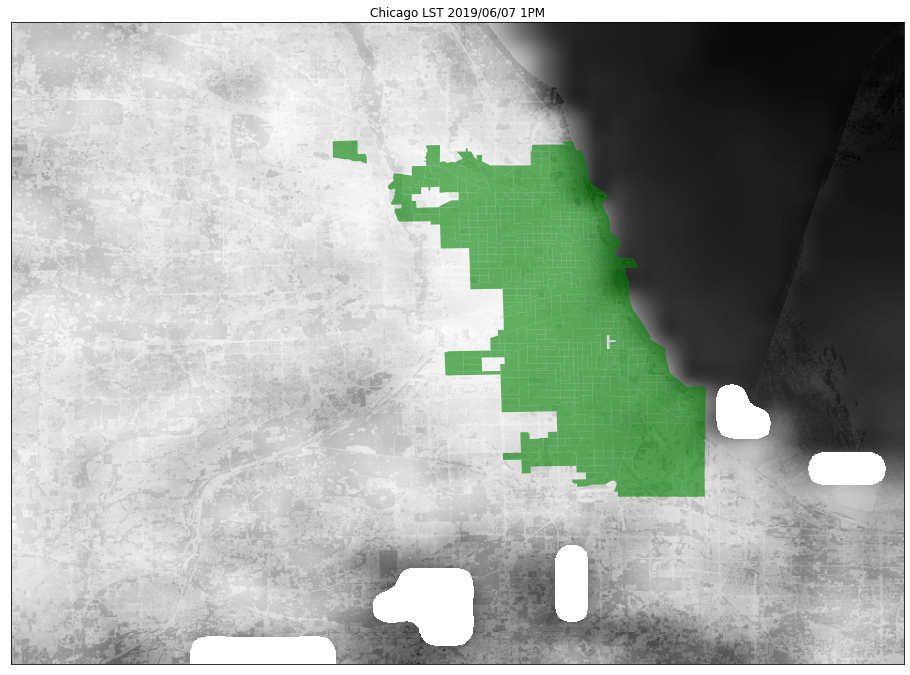

In [38]:
# check the overlap between LST and census tract boundaries
fig, ax = plt.subplots(figsize=(16, 16))

ep.plot_bands(chicago_lst,
              extent=extent,
              title="Chicago LST 2019/06/07 1PM",
              ax = ax,
              cbar=False);

chi_tract.plot(ax=ax, alpha=.6, color='g');

In [39]:
# extract LST pixel values for each tract
avg_LST_tract = []

with rio.open(chicago_lst_tif) as src_raster:
  for idx, row in chi_tract.iterrows():
    cropped_raster, cropped_meta = es.crop_image(src_raster, row['geometry'], all_touched=False)
    avg_LST_tract.append(np.nanmean(
        cropped_raster[cropped_raster > 0]
    ) - 273.15) # convert Kelvin to Celcius

    if idx % 100 == 99:
      print('Processing ', idx + 1)

print('Done.')      

Processing  100
Processing  200
Processing  300
Processing  400
Processing  500
Processing  600
Processing  700
Done.


In [40]:
chi_tract['avg_LST'] = avg_LST_tract

In [41]:
chi_tract

,geoid10,geometry,pop,log_pop,hhd_inc,log_inc,pcnt_blw_pov,avg_LST
0,17031842400,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",3084,3.489114,39161.0,4.592854,26.10,32.750509
1,17031840300,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",3917,3.592954,48056.0,4.681748,18.47,35.570737
2,17031841100,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",6821,3.833848,26905.0,4.429833,37.30,29.589300
3,17031841200,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ...",5183,3.714581,36104.0,4.557555,26.61,36.266804
4,17031839000,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ...",8542,3.931560,84347.0,4.926070,20.21,24.224767
...,...,...,...,...,...,...,...,...
791,17031070400,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ...",3228,3.508934,90125.0,4.954845,12.52,33.685268
792,17031070500,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ...",3229,3.509068,120885.0,5.082372,6.20,35.036825
793,17031130300,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ...",5532,3.742882,58214.0,4.765027,17.93,35.095161
794,17031292200,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ...",2922,3.465680,31902.0,4.503818,42.97,37.429181


# Visualize

## High-resolution land-surface temperature

In [42]:
def mapvalue2color(value, cmap): 
    """
    Map a pixel value of image to a color in the rgba format. 
    As a special case, nans will be mapped totally transparent.
    
    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)    
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 0.85)

#uchicago_loc = [41.7886, -87.5987]
center_loc = [41.8569, -87.6737]
bounds = [[boundary.bottom, boundary.left], [boundary.top, boundary.right]]

# Create a map using the Map() function and the coordinates for Chicago, IL
m = folium.Map(location=center_loc, 
               tiles='Stamen Terrain', 
               width='50%',
               height='90%',
               zoom_start=11)

# adjust the color map
import branca.colormap as cm
tmin = 15 # degrees Celcius
tmax = 40 # degrees Celcius
tmp_color = cm.linear.RdBu_11.colors.copy()
tmp_color.reverse()
colormap = cm.LinearColormap(
    colors = tmp_color, 
    vmin = tmin, 
    vmax = tmax)
print('Chicago LST 2019/06/07 1PM')

# overlay the raster
folium.raster_layers.ImageOverlay(
    image = chicago_lst - 273.15,
    opacity = 0.7,
    pixelated = True,
    bounds = bounds,
    colormap = lambda value: mapvalue2color(value, colormap)
).add_to(m)

#folium.Marker(uchicago_loc, popup='UChicago').add_to(m)

#folium.LayerControl().add_to(m)
#colormap.caption = 'Land surface temperature (degree)'
#m.add_child(colormap)

title_html = '''
     <head><style> html { overflow-y: hidden; } </style></head>
''' 

m.get_root().html.add_child(folium.Element(title_html))

display(m)


Chicago LST 2019/06/07 1PM


## Tract-by-tract land surface temperature vs. household income


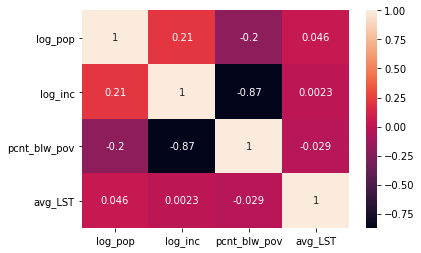

In [43]:
selected_columns = ['log_pop', 'log_inc', 'pcnt_blw_pov', 'avg_LST']

# correlations
corrMat = chi_tract[selected_columns].dropna().corr(method='spearman')
sns.heatmap(corrMat, annot=True)
plt.show()

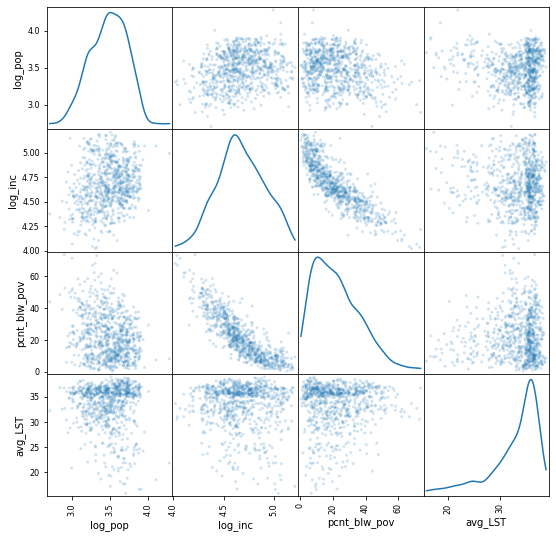

In [44]:
# scatter plots
ax = scatter_matrix(chi_tract[selected_columns].dropna(),
                    alpha=0.2, figsize=(9,9), diagonal='kde')

In [45]:
# change CRS for better visualization
chi_tract = chi_tract.to_crs(epsg=3528)

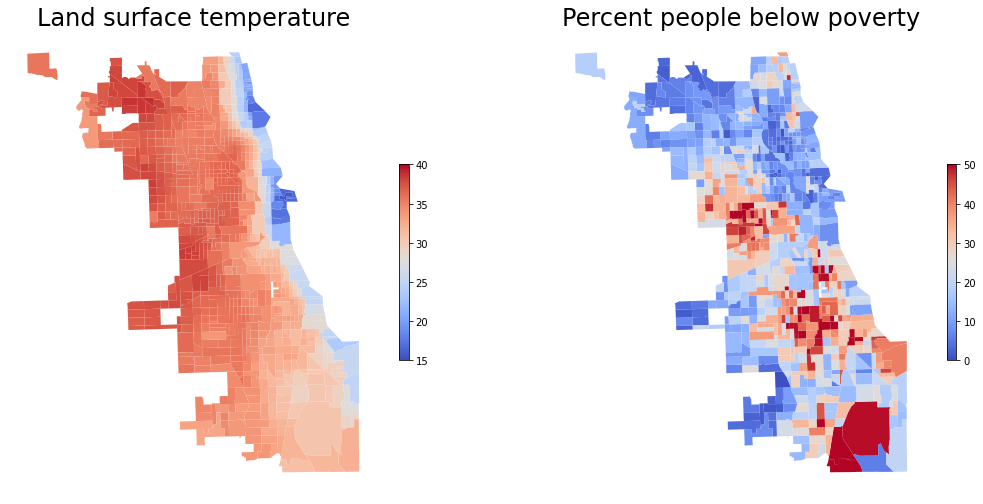

In [46]:
fig, ax = plt.subplots(1,2, figsize=(18,12))

# Mean land surface temperature by census tract
bx = chi_tract.plot(column = 'avg_LST', 
                    vmin = 15, vmax = 40, cmap="coolwarm", 
                    legend=True, legend_kwds={'shrink': 0.3}, ax=ax[0])
bx.set_title('Land surface temperature', fontsize= 24)
bx.xaxis.set_major_locator(plt.NullLocator())
bx.yaxis.set_major_locator(plt.NullLocator())
bx.set_axis_off()
bx.set_axis_on()
for a in ["bottom", "top", "right", "left"]:
  bx.spines[a].set_linewidth(0)

# pcnt below poverty
cx = chi_tract.plot(column = 'pcnt_blw_pov', 
                    vmin = 0, vmax = 50, cmap="coolwarm", 
                    legend=True, legend_kwds={'shrink': 0.3}, ax=ax[1])
cx.set_title('Percent people below poverty', fontsize= 24)
cx.xaxis.set_major_locator(plt.NullLocator())
cx.yaxis.set_major_locator(plt.NullLocator())
cx.set_axis_off()
cx.set_axis_on()
for a in ["bottom", "top", "right", "left"]:
  cx.spines[a].set_linewidth(0)




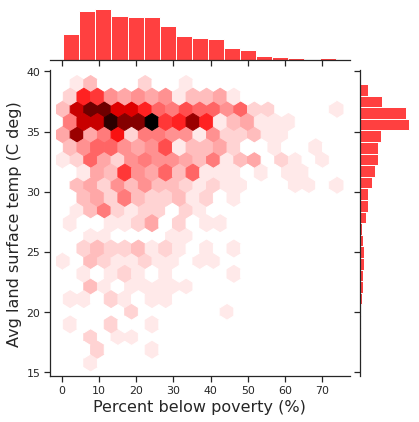

In [47]:
# percent people below poverty VS. LST

sns.set_theme(style="ticks")
g = sns.jointplot(x = chi_tract['pcnt_blw_pov'], 
                  y = chi_tract['avg_LST'], 
                  kind="hex", color='red')

g.set_axis_labels('Percent below poverty (%)', 'Avg land surface temp (C deg)', fontsize=16)
plt.show()